<a href="https://colab.research.google.com/github/cps41/health-informatics-portfolio/blob/main/bigquery_fhir_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FHIR Healthcare Metrics
*Note:* I wrote this notebook using Google Colab, so viewing/executing elsewhere may cause slight differences in appearance and rendering.

# Background
For this assignment I will be using the assigned scenario, as well as prior assignment efforts, to come up with metrics that meet stakeholder needs, design a data model to best do so, and work with a database structured with FHIR resources. Of the provided initiatives, I chose to create metrics for Enhanced Patient Triage System, Medication Adherence Programs, and Telemedicine Services. These are defined as follows:

  -	*Enhanced Patient Triage Systems:* Changes to how patients are seen, prioritized and allocated in the waiting rooms
  -	*Medication Adherence Programs:* Aimed at ensuring patients follow their prescribed medication regimens, reducing readmission rates and improving treatment outcomes.
  -	*Telemedicine Services:* Introduce to provide remote consultations and follow-ups, aimed at increasing accessibility and reducing the burden on physical facilities


# The Metrics



## Enhanced Patient Triage System

For tracking the outcome of improving the patient triage system, it would be important for stakeholders to be able to know the ongoing changes in wait time per patient visit. By tracking the average wait time per visit over time, one can assume that decreases in overall wait times would indicate more efficient triaging systems. To get even more details, they could further refine this metric by tracking average wait time per visit by priority. Since prioritizing critical cases first is important, it may cause patients with less severe cases to have a higher wait time, which could cause the averages to overall stay the same. Ideally, the business would want overall wait times to go down though.

### Assumptions

For this scenario I will be assuming that in their system, an encounter is logged per appointment, and that encounter start times indicate when the patient is actually first seen/treated. I will also be assuming that the stakeholders want to first focus on overall wait times going down and will break down by priority as determined necessary for individual efforts.


## Medication Adherence Programs

To track whether efforts to improve quality of care improves with new medication adherence programs are working or not, I chose to track total readmissions due to adverse medication effects per month. This may demonstrate a direct correlation between the programs and reduced readmissions if they are successful.


### Assumptions

I have assumed that this network uses ICD-10 codes for encounter readmission types. From there, readmissions with a code of type T36–T50 would indicate a reasoning of adverse medication effects (ICD10Data.com 2025). Lastly, the FHIR version the business is using uses the Encounter.hospitalization.reAdmission attribute to indicate an encounter is a readmission.


## Telemedicine Services

By introducing telemedicine appointments, the network hopes to improve quality of care. Increasing accessibility allows for early/preventative treatment of conditions and generally shows reductions in readmissions (Kripalani et al. 2020). As such, I chose to create a metric for the business that tracks the ratio of total readmissions to total telehealth encounters over each month. Fewer readmissions for an increase in telehealth appointments would indicate a successful correlation in the impact of the initiative.


### Assumptions

I have assumed that this network uses the VR code for Encounter.class.code to indicate virtual encounters. Virtual in this case is synonymous with telehealth. Again, I’ve assumed the FHIR version the business is using uses the Encounter.hospitalization.reAdmission attribute to indicate an encounter is a readmission. I am also assuming the start of this initiative will not directly overlap with the others, thus mitigating the risk that incorrect assumptions about the improvements made by one get attributed to the other.

## Data Models
To complete analysis of these metrics, I will be following the Kimball Dimension Method.

## Entity Relationship Diagram
Let's demonstrate this model using an ERD, or entity relationship diagram. This will be generated using mermaid.js and Python based on the Mermaid documentation (Mermaid n.d.).

You can clearly see we've limited our details down and are following the principles of the Kimball method to have a one to many relationship between fact and dimension tables, as well as having surrofate ids in the dimension tables (Kimball 2013).

# Data Generation

In my [prior assignment](https://drive.google.com/file/d/1h-MhuThGciUxQoL9-gmustlxhO4KYV5f/view?usp=sharing), I used the FHIR Synthea public dataset to create a Kimball Dimensional Model. I will be using that as the foundation for this effort. This is the original schema:

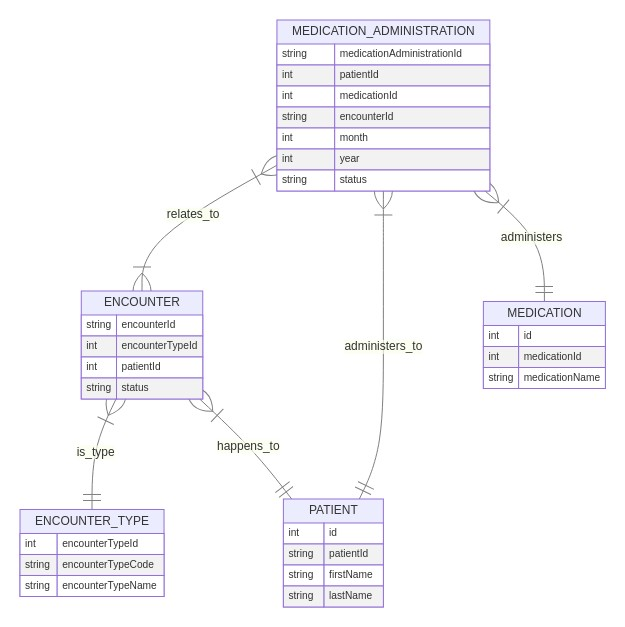

I will need some extra information for the metrics I am working with, so I will be creating the following new schema:

In [5]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
erDiagram
	PATIENT {
		int id
		string patientId
    string firstName
    string lastName
	}
	MEDICATION {
		int id
		int medicationId
		string medicationName
	}
	ENCOUNTER_TYPE {
		int encounterTypeId
		string encounterTypeCode
		string encounterTypeName
	}
	ENCOUNTER {
		string encounterId
		int patientId
		string status
		int readmissionTypeId
		int encounterTypeId
		int encounterClassId
	}
	READMISSION_TYPE {
		int readmissionTypeId
		string readmissionTypeCode
		string readmissionTypeName
	}
	ENCOUNTER_CLASS_TYPE {
		int encounterClassTypeId
		string encounterClassTypeCode
		string encounterClassTypeName
	}
	APPOINTMENT {
		string appointmentId
		string startTime
		string endTime
	}
	MEDICATION_ADMINISTRATION {
		string medicationAdministrationId
		int patientId
		int medicationId
		string encounterId
		int month
		int year
		string status
	}

	ENCOUNTER ||--|| APPOINTMENT : encapsulates
	ENCOUNTER }|--|| ENCOUNTER_TYPE : is_type
	ENCOUNTER }|--|| ENCOUNTER_CLASS_TYPE : is_type
	ENCOUNTER }|--|| READMISSION_TYPE : is_type
	MEDICATION_ADMINISTRATION }|--|{ ENCOUNTER : relates_to
	MEDICATION_ADMINISTRATION }|--|| PATIENT : administers_to
	ENCOUNTER }|--|| PATIENT : happens_to
	MEDICATION_ADMINISTRATION }|--|| MEDICATION : administers
""")



For some of the metrics I will need data that is not generated by the FHIR Synthea project and has not been populated in the public dataset in BigQuery. As such, I will generate reasonable data points for simulation.

Missing Data:
- Appointment.startTime/endTime
- Encounter.admission.reAdmission
  - code
  - text

In [6]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

PROJECT_ID = "insert-project-id"
client = bigquery.Client(project=PROJECT_ID);

Authenticated


In [7]:
DATASET_ID = "fhir_data_metrics"
DATASET = bigquery.Dataset(f"{PROJECT_ID}.{DATASET_ID}")

## Readmission Type Table

Let's begin creating the dimension table for readmission types.

In [8]:
# First create the table
# Follow the schema presented in our ERD
client.query(
f'''  CREATE OR REPLACE TABLE {DATASET_ID}.readmission_type (
    readmissionTypeId INT,
    readmissionTypeCode STRING,
    readmissionTypeName STRING
  );
''').result()

readmission_type_table = client.get_table(f"{DATASET_ID}.readmission_type")
readmission_type_table_name = f"{DATASET_ID}.{readmission_type_table.table_id}"
print(f"Successfully created table {readmission_type_table}")

Successfully created table assignment-1-448801.portfolio_data_modeling.readmission_type


See [my explanation of the optimization](https://colab.research.google.com/drive/1h-MhuThGciUxQoL9-gmustlxhO4KYV5f#scrollTo=O70VdslqEsNf) in my prior assignment.

In [9]:
# Add optimization features
client.query(
f'''
  -- Make searching for text in the readmissionTypeName more efficient
  CREATE SEARCH INDEX readmission_type_index
  ON `{readmission_type_table_name}`(readmissionTypeName);
''')

QueryJob<project=assignment-1-448801, location=US, id=44e87355-e882-4511-82e9-f1a76c8a9225>

If it were populated, I would grab the distinct `encounter.reason` attribute from the FHIR Synthea encounter table for each `encounter.hospitalization.reAdmission` that indicates a readmission instance. Unfortunately, this data is missing from the table, so I created a random sample.

To create the data, I used the help of an AI chatbot to generate a csv formatted list of possible encounter reason codes and their display. I made sure to include some that indicated adverse medication effects so they would be useful for the Medication Adherence Program metric.

I then created a local csv file and uploaded it into my BigQuery project under the table `rt_base`.

In [10]:
client.query(
f'''
  CREATE OR REPLACE TABLE
    `{readmission_type_table_name}` AS
  SELECT
    -- Create unique incremental id for rows as a surrogate id
    ROW_NUMBER() OVER (ORDER BY readmissionTypeCode, readmissionTypeName) AS readmissionTypeId,
    readmissionTypeCode,
    readmissionTypeName
  FROM (
    -- Use generated table data
    SELECT
      DISTINCT code AS readmissionTypeCode,
      display AS readmissionTypeName
    FROM
      `{DATASET_ID}.rt_base`
    ORDER BY
      code);
''').result()

Let's do a quick check to see some of the data we just handled.

In [11]:
# Quick check to see if rows populated
client.query(
f'''
  SELECT *
  FROM {readmission_type_table_name}
  LIMIT 10
''').to_dataframe()

,readmissionTypeId,readmissionTypeCode,readmissionTypeName
0,27,K21.0,Gastroesophageal Reflux Disease with Esophagitis
1,36,M54.5,Low Back Pain
2,62,T44.3X1A,"Poisoning by Antihistamines, Initial Encounter"
3,65,T45.5X1A,"Poisoning by Antibiotics, Initial Encounter"
4,99,T66.0X1A,"Radiation Poisoning, Initial Encounter"
5,1,A41.9,"Sepsis, Unspecified"
6,18,I50.9,"Heart Failure, Unspecified"
7,46,R29.9,Unspecified Symptoms and Signs Involving the N...
8,51,T36.0X1A,Adverse Effect of Penicillin and Its Derivativ...
9,73,T48.3X1A,"Poisoning by Diuretics, Initial Encounter"


##### Validation
Now let's perform some validation to see if the data matches our expectations.

In [12]:
client.query(
f'''
  -- Get total number of rows
  SELECT COUNT(*) as totalRows,
    -- Get total unique ids
    COUNT(DISTINCT readmissionTypeId) as totalIds,
    -- Get total unique codes
    COUNT(DISTINCT readmissionTypeId) as totalCodes,
  FROM {readmission_type_table_name}
''').to_dataframe()

,totalRows,totalIds,totalCodes
0,129,129,129


As expected, we get the same count across all, meaning all values are unique without duplicates. Now lets check for NULL values.

In [13]:
client.query(
    f'''
      SELECT COUNT(*) as totalNulls
      FROM {readmission_type_table_name}
      WHERE readmissionTypeId IS NULL
        OR readmissionTypeCode IS NULL
        OR readmissionTypeName IS NULL
    '''
).to_dataframe()

,totalNulls
0,0


We can now see there are no NULL values for any of our required elements.

## Encounter Class Type Table

In [ ]:
# First create the table
# Follow the schema presented in our ERD
client.query(
f'''  CREATE OR REPLACE TABLE {DATASET_ID}.encounter_class_type (
    encounterClassTypeId INT,
    encounterClassTypeCode STRING,
    encounterClassTypeName STRING
  );
''').result()

encounter_class_type_table = client.get_table(f"{DATASET_ID}.encounter_class_type")
encounter_class_type_table_name = f"{DATASET_ID}.{encounter_class_type_table.table_id}"
print(f"Successfully created table {encounter_class_type_table}")

In [ ]:
# Add optimization features
client.query(
f'''
  -- Make searching for text in the encounterClassTypeName more efficient
  CREATE SEARCH INDEX encounter_class_type_index
  ON `{encounter_class_type_table_name}`(encounterClassTypeName);
''')

Unlike the readmission types, we have populated data to work with. We will use the `encounter.class.code` and `encounter.class.display` to populate `encounterClassTypeCode` and `encounterClassTypeName` respectively.

In [ ]:
client.query(
f'''
  CREATE OR REPLACE TABLE
    `{encounter_class_type_table_name}` AS
  SELECT
    -- Create unique incremental id for rows as a surrogate id
    ROW_NUMBER() OVER (ORDER BY encounterClassTypeCode, encounterClassTypeName) AS encounterClassTypeId,
    encounterClassTypeCode,
    encounterClassTypeName
  FROM (
    SELECT
      DISTINCT class.code AS encounterClassTypeCode,
      class.display AS encounterClassTypeName
    FROM
      `bigquery-public-data.fhir_synthea.encounter`
  );
''').result()

Let's do a quick check to see some of the data we just handled.

In [14]:
# Quick check to see if rows populated
client.query(
f'''
  SELECT *
  FROM {encounter_class_type_table_name}
  LIMIT 10
''').to_dataframe()

NameError: name 'encounter_class_type_table_name' is not defined

Looks like the dataset does not include the display names or any telehealth encounters. Let's add the encounterClassTypeNames sourced from [the encounter class expansion documentation](https://terminology.hl7.org/6.1.0/ValueSet-encounter-class.html#expansion) since there are only three.

In [ ]:
client.query(f'''
  -- Set ambulatory
  UPDATE `{encounter_class_type_table_name}`
  SET encounterClassTypeName = 'ambulatory'
  WHERE encounterClassTypeCode = 'AMB';
  -- Set emergency type
  UPDATE `{encounter_class_type_table_name}`
  SET encounterClassTypeName = 'emergency'
  WHERE encounterClassTypeCode = 'EMER';
  -- Set inpatient type
  UPDATE `{encounter_class_type_table_name}`
  SET encounterClassTypeName = 'inpatient encounter'
  WHERE encounterClassTypeCode = 'IMP';
''').result()

Now let's add the telehealth class type.

In [ ]:
client.query(f'''
  INSERT INTO `{encounter_class_type_table_name}`
    (encounterClassTypeId, encounterClassTypeCode, encounterClassTypeName)
  VALUES (4, 'VR', 'virtual');
''').result()

##### Validation
Now let's perform some validation to see if the data matches our expectations.

In [ ]:
client.query(
f'''
  -- Get total number of rows
  SELECT COUNT(*) as totalRows,
    -- Get total unique ids
    COUNT(DISTINCT encounterClassTypeId) as totalIds,
    -- Get total unique codes
    COUNT(DISTINCT encounterClassTypeId) as totalCodes,
    -- Get total unique names
    COUNT(DISTINCT encounterClassTypeName) as totalNames
  FROM {encounter_class_type_table_name}
''').to_dataframe()

As expected, we get the same count across all, meaning all values are unique without duplicates. Now lets check for NULL values.

In [ ]:
client.query(
    f'''
      SELECT COUNT(*) as totalNulls
      FROM {encounter_class_type_table_name}
      WHERE encounterClassTypeId IS NULL
        OR encounterClassTypeCode IS NULL
        OR encounterClassTypeName IS NULL
    '''
).to_dataframe()

We can now see there are no NULL values for any of our required elements.

## Appointment Table

The appointment table will be a bit more complicate than the readmission and encounter class type tables because it is both a fact table and needs the data to sync appropriately and reasonably with the existing encounter facts. Since we are dealing with millions of records (over 90 million for the encounter table), it will be best to generate the data incrementally. I will use python functions to do this cleanly.

To iterate across the encounter table consistently, let's create an enumerated temp table. This will allow us to perform actions over portions of the data since the encounter ids are unordered GUIDs and BigQuery doesn't return them in the same order each query.

In [2]:
def create_numbered_encounter_table() -> str:
  ''' Create a temp table for numerated encounter rows to
      iterate over and populate appointments incrementally. '''
  temp_encounter_table_name = f"{DATASET_ID}.temp_encounter"
  client.query(f'''
    CREATE OR REPLACE TABLE `{temp_encounter_table_name}`
    AS (
      -- Get an incremented int for each encounter row
      SELECT ROW_NUMBER() OVER (ORDER BY encounterId) AS rowNum,
      *
      FROM `{DATASET_ID}.encounter`
    )
  ''').result()
  return temp_encounter_table_name

Next we will need to generate data for the portion of encounters selected. Using a limit and an offset that increment evenly will allow us to work on windowed portions of data.

Since we can only worth it so much data in-memory, and dataframes are not efficient to work over incrementally, I've opted to conver the subset of encounters into a dictionary. This allows us to create a unique appointment id and a random appointment start time up to six hours before the encounter starts. For completeness I've also created a random appointment end time, which by FHIR standards does not have to align with the encounter end time.

*Note:* Both the encounterId and encounterTypeId are needed to obtain unique records. This follows the FHIR Synthea data creation methods.

In [30]:
import uuid
import random
from dateutil import parser
from datetime import timedelta

def get_appointment_info(temp_encounter_table_name:str, limit:int, offset:int) -> pd.DataFrame:
  """ Get a portion of encounters to create appointments for. Generate
      reasonable data for appointments. """
  # grab the encounters to iterate through and update
  encounter_info = client.query(f'''
    -- encounterId, encounterTypeId gives us unique rows to handle
    SELECT encounterId, encounterTypeId, startTime
    FROM `{temp_encounter_table_name}`
    LIMIT {limit} OFFSET {offset}
  ''').to_arrow().to_pandas().to_dict("records") # convert to dict for optimization

  # create dict to convert to df after populating with data
  appts = {
      "appointmentId": [],
      "encounterTypeId": [],
      "startTime": [],
      "endTime": [],
      "encounterId": []
  }

  # create a random appointment id, start time, and end time per encounter
  for encounter in encounter_info:
    appts["encounterId"].append(encounter["encounterId"])
    appts["encounterTypeId"].append(encounter["encounterTypeId"])
    # create random UUID for appointment
    appts["appointmentId"].append(str(uuid.uuid4()))
    # create appointment start time up to 6 hrs before encounter starts
    appt_start_time = parser.isoparse(encounter["startTime"]) + timedelta(minutes=random.randint(-60*6, 0))
    # create appointment end time 15 minutes up to 6 hrs after appointment starts
    app_end_time = appt_start_time + timedelta(minutes=random.randint(15, 60*4))
    # follow pre-defined schema of strings
    appts["startTime"].append(str(appt_start_time))
    appts["endTime"].append(str(app_end_time))

  temp_appts_df = pd.DataFrame(appts)
  return temp_appts_df

The optimal method of appending this created data to the encounter fact table will be to merge them. As such, we need to create a temp table using the dataframe from the generated appointment info. We need the encounterId and encounterTypeId for the merge.

In [31]:
def populate_temp_table(temp_appts_df:str) -> str:
  """ Populate a temp table with the generated data """
  temp_table_name = f"{DATASET_ID}.temp_appointment"
  # Create the temp table, overwriting an existing one with the job config
  client.load_table_from_dataframe(temp_appts_df, temp_table_name,
      job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")).result()
  # Confirm creation
  temp_table = client.get_table(temp_table_name)
  print(f"Created and loaded {temp_appts_df.shape[0]} rows into {temp_table_name}.")
  return temp_table_name

Now we can merge the data into the encounter table, setting the associated appointmentId.

In [32]:
# Populate encounter table with appointment ids
def merge_appointment_ids_to_encounter():
  client.query(f'''
    MERGE INTO `{DATASET_ID}.encounter` AS target
    USING `{temp_table_name}` AS source
      -- encounterId, encounterTypeId gives us unique rows to handle
      ON target.encounterId = source.encounterId AND target.encounterTypeId = source.encounterTypeId
    WHEN MATCHED THEN
      UPDATE SET target.appointmentId = source.appointmentId
  ''')

Similar to how we populated the temp table, we can create and populate the appointment table with a subset of the dataframe columns, since we don't need the encounterId or encounterTypeId here.

In [33]:
def populate_appointment_table(temp_appts_df:pd.DataFrame):
  """ Populate appointment table with the generated data """
  # Append to the appointment table with the generated data
  appointment_table_name = f"{DATASET_ID}.appointment"
  # Filter out data for appointments fact table
  appointment_details_df = temp_appts_df[["appointmentId", "startTime", "endTime"]]
  # Load data into table
  client.load_table_from_dataframe(appointment_details_df, appointment_table_name).result()
  # Confirm creation
  appointment_table = client.get_table(appointment_table_name)
  print(f"Created and loaded {appointment_details_df.shape[0]} rows into {appointment_table_name}.")

And eventually we will want to clean up our dataset by removing the temp tables.

In [34]:
def clean_up_temp_tables(temp_appointment_info:str, temp_encounter:str):
  ''' Clean up temporary tables. '''
  client.delete_table(temp_appointment_info, not_found_ok=True)
  client.delete_table(temp_encounter, not_found_ok=True)

We will be adding multiple new columns to our schema. For consistency it makes sense to create a function to handle checking if the column already exists and creating it if not.

In [35]:
def add_column_to_table(column_name:str, target_table_name:str, column_type:str):
  # Create the column if it does not already exist
  column_exists_query = client.query(f'''
    SELECT COUNT(*) AS column_exists
    FROM `{DATASET_ID}.INFORMATION_SCHEMA.COLUMNS`
    WHERE table_name = '{target_table_name}'
    AND column_name = '{column_name}';
  ''').result()
  column_exists = column_exists_query.to_dataframe()['column_exists'][0]

  if column_exists == 0:
    client.query(
    f'''
        ALTER TABLE `{DATASET_ID}.{target_table_name}`
        ADD COLUMN {column_name} {column_type}
    ''').result()
    print(f"Successfully added column {column_name} to {target_table_name}")
  else:
    print(f"Column {column_name} already exists in {target_table_name}")

Before starting our loop, let's add the new column and create our enumerated encounter table to iterate over.

In [ ]:
# Create the column in the encounter table for appointmentId
add_column_to_table('appointmentId', 'encounter', 'INT')

# Create enumerated encounter temp table to iterate over
temp_encounter_table_name = create_numbered_encounter_table()

This process takes a long time, so I've tried to mess around with the `window_size` to get a sufficient tradeoff between overall time and records processed. **Too large of a window size will use up too much RAM and cause the runtime to crash.** I was able to run it in ~10 minutes, though this may vary with available BigQuery/Colab resources.

In [ ]:
length_of_encounters = 10000000

# Segment the encounter table and generate appointment data incrementally for memory and performance
window_size = 1000000
for offset in range(0, length_of_encounters, window_size):
  print(f'Processing records {offset+1} to {offset + window_size}...')
  # Generate appointment data for range of encounters
  temp_appts_df = get_appointment_info(temp_encounter_table_name, window_size, offset)
  # Place new data in a temp table
  temp_table_name = populate_temp_table(temp_appts_df)
  # Populate appointment table
  populate_appointment_table(temp_appts_df)
  # Update the encounters with the appointment ids
  merge_appointment_ids_to_encounter()
  print(f'Processed records {offset+1} to {offset + window_size}!')

In [ ]:
# Clear the temp tables
clean_up_temp_tables(f'{DATASET_ID}.temp_appointment', f'{DATASET_ID}.temp_encounter')

## Encounter Table

Now let's use the existing data and new dimension tables to add to our encounter fact table.

### Start Times

We will need the `encounter.startTime` column for our *Enhanced Patient Triaging* metric. For completeness let's include `encounter.endTime`.

In [ ]:
# Add start and end time columns to encounter fact table
add_column_to_table("startTime", "encounter", "INT")
add_column_to_table("endTime", "encounter", "INT")

We will use the existing `encounter.period` data to populate.

In [16]:
# Populate start and end times
client.query(f"""
  MERGE INTO `{DATASET_ID}.encounter` AS target
  USING `bigquery-public-data.fhir_synthea.encounter` AS source
    ON target.encounterId = source.id
  WHEN MATCHED THEN
    UPDATE SET
      target.startTime = source.period.start,
      target.endTime = source.period.end
""").result()

### Readmission Types

For the readmission types, we will be assigning a randomly selected readmission type from the dimension table to a subset of encounters.

In [ ]:
add_column_to_table("readmissionTypeId", f"encounter", "INT")

In [ ]:
# grab the readmission types to randomly assign
readmission_types_iterator = client.query(f'''
  SELECT readmissionTypeId
  FROM `{DATASET_ID}.readmission_type`
''').to_arrow().to_pandas().to_dict("records")
readmission_types = [item['readmissionTypeId'] for item in readmission_types_iterator]

For our evaluation, we will only be analyzing the metrics for a subset of time since the records date back over decades. I am making an additional assumption that it is unnecessary for the stakeholders to analyze data before 2000.

In [ ]:
# grab the encounters to iterate through and update
encounter_ids = client.query(f'''
  SELECT DISTINCT encounterId, encounterTypeId
  -- Use TABLESAMPLE to get random selection from the encounter table
  -- Randomly select sample size
  FROM `{DATASET_ID}.encounter` TABLESAMPLE SYSTEM(5 PERCENT)
  -- Only grab records from 2000 and later
  WHERE EXTRACT(YEAR FROM TIMESTAMP(startTime)) >= 2000
''').to_arrow().to_pandas().to_dict("records") # convert to dict for optimization


Now we can assign a random choice from the readmission_type table to each encounter.

In [ ]:
import random
import pandas as pd
from google.cloud import bigquery

# Create list of (encounterId, readmissionTypeId) tuples
readmission_info = {
    "encounterId": [],
    "encounterTypeId": [],
    "readmissionTypeId": []
}
# Populate with random readmission types
for encounter in encounter_ids:
  readmission_info["encounterId"].append(encounter["encounterId"])
  readmission_info["encounterTypeId"].append(encounter["encounterTypeId"])
  readmission_info["readmissionTypeId"].append(random.choice(readmission_types))

# Convert to Pandas DataFrame
readmission_info_df = pd.DataFrame(readmission_info, columns=readmission_info.keys())
readmission_info_df.head()

Create a temp table that we will use to merge with the encounter table.

In [ ]:
# Load DataFrame into a temporary BigQuery table
temp_table_id = f"{PROJECT_ID}.{DATASET_ID}.temp_readmission_updates"
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")  # Overwrites temp table
client.load_table_from_dataframe(readmission_info_df, temp_table_id, job_config=job_config).result()

Set the random values in the encounter fact table

In [ ]:
# Perform update using MERGE
client.query(f"""
  MERGE INTO `{DATASET_ID}.encounter` AS target
  USING `{DATASET_ID}.temp_readmission_updates` AS source
  ON target.encounterId = source.encounterId
    AND target.encounterTypeId = source.encounterTypeId
  WHEN MATCHED THEN
    UPDATE SET target.readmissionTypeId = source.readmissionTypeId
""").result()

Clean up the temp table and check our work.

In [ ]:
# # Clean up temporary table
client.delete_table(temp_table_id, not_found_ok=True)

# Fetch updated results
client.query(f"""
  SELECT e.encounterId, e.readmissionTypeId, rt.readmissionTypeName, rt.readmissionTypeCode
  FROM `{DATASET_ID}.encounter` e
  JOIN `{DATASET_ID}.readmission_type` rt
    ON rt.readmissionTypeId = e.readmissionTypeId
  ORDER BY RAND()
  LIMIT 100
""").to_dataframe()

### Encounter Class Types
This is needed to determine if the encounter is of telehealth type. We will need to add the encounterClassId column to the encounter fact table, and create a dimension for encounter classes holding their id, code, and name. Based on [encounter class codes](https://terminology.hl7.org/6.1.0/ValueSet-encounter-class.html#logical-definition-cld).

Let's attach the encounter classes to our model. The FHIR Synthea dataset contains these values in `encounter.class.code`, so we can merge this data with the encounter fact table. Unfortunately, we need the encounterClassTypeId as the surrogate identifier to follow the Kimball methods.

First we need to create a temp table to join the surrogate id for the encounter.

In [ ]:
client.query(f'''
  CREATE OR REPLACE TABLE `{DATASET_ID}.temp_encounter_classes` AS (
    SELECT e.id, e.class.code as code, ct.encounterClassTypeId as classId
    FROM `bigquery-public-data.fhir_synthea.encounter` e
    JOIN `{DATASET_ID}.encounter_class_type` ct
      ON e.class.code = ct.encounterClassTypeCode
  )
''').result()

Then create the new column.

In [ ]:
# Create the encounterClassId column
column_name = "encounterClassId"
add_column_to_table(column_name, f"encounter", "INT")

Merge the identified class data into the encounter table.

In [ ]:

# Merge existing data with our model
client.query(f"""
MERGE INTO `{DATASET_ID}.encounter` AS target
  USING `{DATASET_ID}.temp_encounter_classes` AS source
    ON target.encounterId = source.id
  WHEN MATCHED THEN
    UPDATE SET
      target.{column_name} = source.classId
""").result()


Now let's see what classes are used.

In [ ]:
client.query(f'''
  SELECT DISTINCT encounterClassId
  FROM `{DATASET_ID}.encounter`
''').to_dataframe()

As we found out when creating the encounter_class_type dimension table, there are no instances of telehealth encounters. For our metric, the simplest and fastet route will be to just swap some encounters to telehealth class types. Generating data for each encounter is a time consuming process, and this meets our needs sufficiently.

We will grab a random, small subset of encounters. I chose to leave out readmissions because I made the assumption that it does not make sense in the business's context for a readmission to be virtual.

In [ ]:
client.query(f'''
  CREATE OR REPLACE TABLE `{DATASET_ID}.temp_sample_encounters` AS (
    SELECT encounterId, encounterTypeId FROM `{DATASET_ID}.encounter`
    -- Get randomly sized sample
    TABLESAMPLE SYSTEM(1 PERCENT)
    -- Get encounters that are not readmissions
    WHERE readmissionTypeId IS NULL
    -- Only grab records from 2000 and later
    AND EXTRACT(YEAR FROM TIMESTAMP(startTime)) >= 2000
  )
''').result()

client.query(f'''
  SELECT * FROM `{DATASET_ID}.temp_sample_encounters` LIMIT 100
''').to_dataframe()

Update the `encounterClassId` to 4 to indicate the random subset of encounters are all telehealth encounters.

In [ ]:
client.query(f'''
  MERGE INTO `{DATASET_ID}.encounter` AS target
  USING `{DATASET_ID}.temp_sample_encounters` AS source
    ON target.encounterId = source.encounterId AND target.encounterTypeId = source.encounterTypeId
  WHEN MATCHED THEN
    UPDATE SET encounterClassId = 4
''').result()

# Metric Creation
**It is worth keeping in mind that since most of the data used is generated randomly, rerunning the steps leading up to this will create different visualizations.**

## Average Wait Time Per Month

As described in the [Enhanced Patient Triage System](https://colab.research.google.com/drive/172M_7CMpRS2WPf_GhFsaT2t4yyukX20i#scrollTo=xEr6Ul88MIIx&line=3&uniqifier=1) section, I chose to create a metric to measure the average wait time each month. This is calculated by taking the average difference between encounter start time and appointment start time each month.

In [22]:
average_wait_time_per_month = client.query(f'''
  WITH converted_data AS (
    SELECT
      e.encounterId,
      TIMESTAMP(e.startTime) AS encounter_time,
      TIMESTAMP(a.startTime) AS appointment_time,
      CONCAT(EXTRACT(YEAR FROM TIMESTAMP(e.startTime)), '_',
        EXTRACT(MONTH FROM TIMESTAMP(e.startTime))) AS encounter_month
    FROM `{DATASET_ID}.encounter` e
    JOIN `{DATASET_ID}.appointment` a
    ON e.appointmentId = a.appointmentId
    WHERE EXTRACT(YEAR FROM TIMESTAMP(e.startTime)) >= 2000
  )
  SELECT
    encounter_month,
    AVG(TIMESTAMP_DIFF(appointment_time, encounter_time, MINUTE)) AS avg_diff_minutes
  FROM converted_data
  GROUP BY encounter_month
  ORDER BY encounter_month;
''').to_dataframe()

To visualize this metric, I chose a simple line graph. This makes it easy to see the trend in wait times and measure if/when they go down.

In [23]:
import plotly.express as px

fig = px.line(average_wait_time_per_month, x='encounter_month', y='avg_diff_minutes')
fig.update_layout(
    title="Average Wait Time per Month",
    xaxis_title="Month",
    yaxis_title="Average Wait Time (minutes)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

## Total Readmissions Per Month

As described in the [Medication Adherence Programs](https://colab.research.google.com/drive/172M_7CMpRS2WPf_GhFsaT2t4yyukX20i#scrollTo=dWWDYVExMM2m&line=3&uniqifier=1) section, I chose to create a metric to measure total readmissions due to adverse medication effects per month. This is calculated by summing the total readmissions with readmission type codes between T36–T50 per month.

In [24]:
readmissions_per_month = client.query(f'''
    WITH adverse_medication_readmission AS(
    SELECT e.encounterId, e.startTime, rt.readmissionTypeCode
    FROM `{DATASET_ID}.encounter` e
    JOIN `{DATASET_ID}.readmission_type` rt
    ON e.readmissionTypeId = rt.readmissionTypeId
    WHERE EXTRACT(YEAR FROM TIMESTAMP(e.startTime)) >= 2010
    -- Get codes starting with T##
    AND REGEXP_CONTAINS(rt.readmissionTypeCode, r'^T\d{2}')
    -- Get codes starting with T36-T50
  AND CAST(SUBSTR(rt.readmissionTypeCode, 2, 2) AS INT64) BETWEEN 36 AND 50

  )
  SELECT
        CONCAT(EXTRACT(YEAR FROM TIMESTAMP(startTime)), '_',
          EXTRACT(MONTH FROM TIMESTAMP(startTime))) AS encounter_month,
        COUNT(readmissionTypeCode) AS total_readmissions
      FROM adverse_medication_readmission
      GROUP BY encounter_month
''').to_dataframe()

Similar to **Average Wait Time Per Month**, I chose a simple line graph for this metric.

In [25]:
import plotly.express as px

fig = px.line(readmissions_per_month, x='encounter_month', y='total_readmissions')
fig.update_layout(
    title="Total Readmissions per Month",
    xaxis_title="Month",
    yaxis_title="Total Readmissions",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

## Ratio of Readmissions to Telehealth Encounters Per Month

As described in the [Telemedicine Services](https://colab.research.google.com/drive/172M_7CMpRS2WPf_GhFsaT2t4yyukX20i#scrollTo=3pAZJapfMcxB&line=1&uniqifier=1) section, I chose to create a metric to measure the ratio of readmissions to telehealth encounters for each month.

In [26]:
average_readmissions_per_month = client.query(f'''
  WITH monthly_telehealth_stats AS (
    SELECT
      CONCAT(EXTRACT(YEAR FROM TIMESTAMP(e.startTime)), '_',
        EXTRACT(MONTH FROM TIMESTAMP(e.startTime))) AS encounter_month,
      -- Get totals for telehealth encounters
      COUNT(DISTINCT
        CASE WHEN encounterClassId = 4
          THEN e.encounterId
          ELSE NULL
        END) AS total_telehealth_encounters,
        -- Get totals for readmissions
      COUNT(DISTINCT
      CASE WHEN readmissionTypeId IS NOT NULL
        THEN e.encounterId
        ELSE NULL
      END) AS telehealth_readmissions
    FROM `{DATASET_ID}.encounter` e
    WHERE EXTRACT(YEAR FROM TIMESTAMP(e.startTime)) >= 2015
    -- Totals per month
    GROUP BY encounter_month
  )
  SELECT
    encounter_month,
    telehealth_readmissions,
    total_telehealth_encounters,
    -- Calculate ratio
    SAFE_DIVIDE(telehealth_readmissions, total_telehealth_encounters) AS readmission_rate
  FROM monthly_telehealth_stats
  ORDER BY encounter_month;
''').to_dataframe()

I initially thought it may be good to show the totals side by side with a grouped bar graph. Unfortunately with such large values it is not easy to see the correlations, as you can see below.

In [27]:
import plotly.graph_objects as go

month = average_readmissions_per_month['encounter_month']
readmissions = average_readmissions_per_month['telehealth_readmissions']
telehealth_encounters = average_readmissions_per_month['total_telehealth_encounters']

fig = go.Figure(data=[
    go.Bar(name='Readmissions', x=month, y=readmissions),
    go.Bar(name='Telehealth Encounters', x=month, y=telehealth_encounters)
])
fig.update_layout(
    title="Ratio of Readmissions to Telehealth Encounters per Month",
    xaxis_title="Month",
    yaxis_title="Count",
    barmode='group',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

So, next I tried to overlay the ratio trend line on top. While the trend line was useful in indicating the actual ratio changes, it still was not a good visualization.

In [28]:
import plotly.graph_objects as go

month = average_readmissions_per_month['encounter_month']
readmissions = average_readmissions_per_month['telehealth_readmissions']
telehealth_encounters = average_readmissions_per_month['total_telehealth_encounters']
readmissions_ratio = average_readmissions_per_month['readmission_rate']

fig = go.Figure()

# Add bar traces
fig.add_trace(go.Bar(name='Readmissions', x=month, y=readmissions))
fig.add_trace(go.Bar(name='Telehealth Encounters', x=month, y=telehealth_encounters))

# Add line trace for the ratio
fig.add_trace(go.Scatter(
    name='Readmission Ratio',
    x=month,
    y=readmissions_ratio,
    mode='lines',
    yaxis='y2',  # Assign to secondary y-axis
    line=dict(color='black', width=2),
    marker=dict(size=6)
))

# Update layout to include a secondary y-axis
fig.update_layout(
    title="Ratio of Readmissions to Telehealth Encounters per Month",
    xaxis_title="Month",
    yaxis_title="Count",
    barmode='group',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    yaxis2=dict(
        title="Readmission Ratio",
        overlaying='y',
        side='right',
        showgrid=False
    )
)

fig.show()

I decided ultimately that the ratio trend line on its own was sufficient for seeing the correlation in telehealth encounters to readmission rate. It was cleaner and more concise, which is what most stakeholders are looking for.

In [29]:
fig = px.line(average_readmissions_per_month, x='encounter_month', y='readmission_rate')
fig.update_layout(
    title="Ratio of Readmissions to Telehealth Encounters per Month",
    xaxis_title="Month",
    yaxis_title="Ratio of Readmissions to Telehealth Encounters",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()